In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import itertools
import os
import sys
import typing
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tabulate
import torch
from IPython.display import Markdown, display
from loguru import logger

torch.set_grad_enabled(False)

from shared_definitions import *
from shared_visualization_utils import *

sys.path.insert(0, os.path.abspath(".."))

sns.set_theme(style="white", context="notebook", rc={"figure.figsize": (14, 10)})


In [3]:
result_df, indirect_effects_by_model_and_dataset, top_heads_by_model_and_dataset = load_and_combine_raw_results()
result_df.head()

2025-05-15 19:12:41.250 | INFO     | shared_definitions:load_and_combine_raw_results:418 - Loading cached results from data/full_results.pkl.gz


model                   dataset  top_n_prompt_acc  \
0  Llama-3.2-1B-Instruct         choose_first_of_3          0.767429   
1  Llama-3.2-1B-Instruct   capitalize_first_letter          0.936907   
2  Llama-3.2-1B-Instruct  capitalize_second_letter          0.110364   
3  Llama-3.2-1B-Instruct            english-french          0.663200   
4  Llama-3.2-1B-Instruct         choose_first_of_5          0.737286   

   top_1_prompt_acc                                      top_n_prompts  \
0          0.888571  [Extract the first token, Output the word at t...   
1          0.963093  [What is the initial letter of this word?, Det...   
2          0.160000  [What's the special letter in this word?, Dete...   
3          0.678224  [English word in French, English word to Frenc...   
4          0.772857  [Find the starting word of the input sequence,...   

   0_shot_acc  1_shot_acc  2_shot_acc  3_shot_acc  4_shot_acc  ...  \
0    0.636667    0.863333    0.896667    0.896667    0.913333  ...   
1    0.000000    0.688525    0.852459    0.918033    0.950820  ...   
2         NaN         NaN         NaN         NaN         NaN  ...   
3    0.011348    0.352482    0.587234    0.662411    0.687943  ...   
4    0.616667    0.810000    0.870000    0.890000    0.940000  ...   

   zs_universal_10_heads_max_acc_layer  zs_universal_20_heads_by_layer_acc  \
0                                  NaN                                 NaN   
1                                  NaN                                 NaN   
2                                  NaN                                 NaN   
3                                  NaN                                 NaN   
4                                  NaN                                 NaN   

   zs_universal_20_heads_max_acc  zs_universal_20_heads_max_acc_layer  \
0                            NaN                                  NaN   
1                            NaN                                  NaN   
2                            NaN                                  NaN   
3                            NaN                                  NaN   
4                            NaN                                  NaN   

   fs_shuffled_universal_40_heads_by_layer_acc  \
0                                          NaN   
1                                          NaN   
2                                          NaN   
3                                          NaN   
4                                          NaN   

   fs_shuffled_universal_40_heads_max_acc  \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                                     NaN   
4                                     NaN   

   fs_shuffled_universal_40_heads_max_acc_layer  \
0                                           NaN   
1                                           NaN   
2                                           NaN   
3                                           NaN   
4                                           NaN   

  zs_universal_40_heads_by_layer_acc  zs_universal_40_heads_max_acc  \
0                                NaN                            NaN   
1                                NaN                            NaN   
2                                NaN                            NaN   
3                                NaN                            NaN   
4                                NaN                            NaN   

   zs_universal_40_heads_max_acc_layer  
0                                  NaN  
1                                  NaN  
2                                  NaN  
3                                  NaN  
4                                  NaN  

[5 rows x 256 columns]

In [4]:
SKIP_OLMO = False
if SKIP_OLMO:
    result_df = result_df[~result_df.model.str.contains("OLMo")]
    indirect_effects_by_model_and_dataset = {
        k: v for k, v in indirect_effects_by_model_and_dataset.items() if "OLMo" not in k
    }
    top_heads_by_model_and_dataset = {k: v for k, v in top_heads_by_model_and_dataset.items() if "OLMo" not in k}

    RELEVANT_MODELS = [model for model in ORDERED_MODELS if "OLMo" not in model]
else:
    RELEVANT_MODELS = ORDERED_MODELS[:]

# RQ1: Can we construct function vectors from prompts?


In [5]:
PLOT_SEM = True  # True for SEM, False for STD, None for neither
USE_ONE_THIRD_LAYER = False
LAYER_PLOT_SUFFIX = "one_third_layer" if USE_ONE_THIRD_LAYER else "max_acc_layer"

result_with_same_layer_acc_df = add_same_layer_results(
    result_df,
    special_type=None,
    include_icl=True,
    use_both_zs_and_fs_for_top_layer=True,
    use_one_third_layer_rule=USE_ONE_THIRD_LAYER,
    # geometric_mean=True,
)

result_with_same_layer_acc_df = add_same_layer_results(
    result_with_same_layer_acc_df,
    special_type="instruct_model",
    n_top_head_values=[10, 20],  # only ran this at 10 and 20
    include_icl=False,  # did not run this for ICL
    use_both_zs_and_fs_for_top_layer=True,
    use_one_third_layer_rule=USE_ONE_THIRD_LAYER,
    # geometric_mean=True,
)


2025-05-15 19:12:42.783 | WARNING  | shared_definitions:find_max_acc_layer:575 - No data for Llama-3.2-1B-Instruct | short | ['fs_shuffled_universal_both_all_40_heads_by_layer_acc', 'zs_universal_both_all_40_heads_by_layer_acc']
2025-05-15 19:12:42.794 | WARNING  | shared_definitions:find_max_acc_layer:575 - No data for Llama-3.2-1B-Instruct | long | ['fs_shuffled_universal_both_all_40_heads_by_layer_acc', 'zs_universal_both_all_40_heads_by_layer_acc']
2025-05-15 19:12:42.808 | WARNING  | shared_definitions:find_max_acc_layer:575 - No data for Llama-3.2-1B-Instruct | both | ['fs_shuffled_universal_both_all_40_heads_by_layer_acc', 'zs_universal_both_all_40_heads_by_layer_acc']
2025-05-15 19:12:42.819 | WARNING  | shared_definitions:find_max_acc_layer:575 - No data for Llama-3.2-1B-Instruct | icl | ['fs_shuffled_universal_40_heads_by_layer_acc', 'zs_universal_40_heads_by_layer_acc']
2025-05-15 19:12:42.832 | WARNING  | shared_definitions:find_max_acc_layer:575 - No data for Llama-3.2-3B 

In [6]:
MISSING_DATASETS_BY_MODEL = {}
n_top_heads = 10

for model in RELEVANT_MODELS:
    model_missing_datasets = set()
    for prompt_type in (SHORT, LONG, ICL):
        model_df = result_with_same_layer_acc_df[
            (result_with_same_layer_acc_df.model == model) & (result_with_same_layer_acc_df.prompt_type == prompt_type)
        ]

        zs_prefix = get_zs_prefix(True)
        universal_layer_acc_key = f"{zs_prefix}_{n_top_heads}_heads_universal_FV_acc"
        missing_datasets = model_df[model_df[universal_layer_acc_key].isna()].dataset.unique()
        model_missing_datasets.update(missing_datasets)

    MISSING_DATASETS_BY_MODEL[model] = model_missing_datasets


row_filter = result_with_same_layer_acc_df.apply(
    lambda row: row.dataset not in MISSING_DATASETS_BY_MODEL[row.model], axis=1
)

matched_datasets_result_with_same_layer_acc_df = result_with_same_layer_acc_df[row_filter].copy(deep=True)

In [7]:
mdf = matched_datasets_result_with_same_layer_acc_df[
    ~matched_datasets_result_with_same_layer_acc_df.zs_universal_both_instruct_model_all_20_heads_same_layer_acc.isna()
]

mdf = mdf.assign(
    instruct_diff_10=mdf.zs_universal_both_instruct_model_all_10_heads_same_layer_acc
    - mdf.zs_universal_both_all_10_heads_same_layer_acc,
    instruct_diff_20=mdf.zs_universal_both_instruct_model_all_20_heads_same_layer_acc
    - mdf.zs_universal_both_all_20_heads_same_layer_acc,
)

mdf.groupby("model")[["instruct_diff_10", "instruct_diff_20"]].agg(["mean", "std"])

instruct_diff_10           instruct_diff_20          
                           mean       std             mean       std
model                                                               
Llama-2-7b-hf          0.034062  0.194997         0.131743  0.217486
Llama-3.1-8B           0.072520  0.186243         0.207666  0.209452
Llama-3.2-1B           0.092267  0.164712         0.077185  0.141509
Llama-3.2-3B           0.054114  0.117807         0.026532  0.128514
OLMo-2-1124-7B         0.057515  0.191841         0.231531  0.224300

In [8]:
from shared_visualization_utils import METRIC_RENAMES, print_summary

# f"{zs_prefix}_{n_top_heads}_heads_universal_FV_acc"


def model_order_key(index):
    return [RELEVANT_MODELS.index(k) if k in RELEVANT_MODELS else -1 for k in index]


summary_columns = (
    [
        "10_shot_acc",
        "top_1_prompt_acc",
        "top_n_prompt_acc",
        "0_shot_acc",
    ]
    + list(
        itertools.chain.from_iterable(
            [
                [
                    f"zs_universal_both_all_{n_top_heads}_heads_same_layer_acc",
                    f"zs_universal_icl_all_{n_top_heads}_heads_same_layer_acc",
                ]
                for n_top_heads in N_TOP_HEADS_VALUES
            ]
        )
    )
    + [f"zs_universal_both_instruct_model_all_{n_top_heads}_heads_same_layer_acc" for n_top_heads in [10, 20]]
)

summary_columns_shuffled_10_shot = (
    [
        "10_shot_acc",
        "top_1_prompt_acc",
        "top_n_prompt_acc",
        "shuffled_10_shot_acc",
    ]
    + list(
        itertools.chain.from_iterable(
            [
                [
                    f"fs_shuffled_universal_both_all_{n_top_heads}_heads_same_layer_acc",
                    f"fs_shuffled_universal_icl_all_{n_top_heads}_heads_same_layer_acc",
                ]
                for n_top_heads in N_TOP_HEADS_VALUES
            ]
        )
    )
    + [f"fs_shuffled_universal_both_instruct_model_all_{n_top_heads}_heads_same_layer_acc" for n_top_heads in [10, 20]]
)


summary_layer_columns = list(
    itertools.chain.from_iterable(
        [
            [
                f"zs_both_{n_top_heads}_max_acc_layer",
                f"zs_both_{n_top_heads}_max_acc_layer_depth",
                f"zs_icl_{n_top_heads}_max_acc_layer",
                f"zs_icl_{n_top_heads}_max_acc_layer_depth",
                f"fs_shuffled_both_{n_top_heads}_max_acc_layer",
                f"fs_shuffled_both_{n_top_heads}_max_acc_layer_depth",
                f"fs_shuffled_icl_{n_top_heads}_max_acc_layer",
                f"fs_shuffled_icl_{n_top_heads}_max_acc_layer_depth",
            ]
            for n_top_heads in N_TOP_HEADS_VALUES
        ]
    )
)


display(Markdown("## Summary (aggregated by model) - 0-shot"))
zero_shot_metric_dicts = print_summary(
    matched_datasets_result_with_same_layer_acc_df, summary_columns, [3, 6], use_sem=PLOT_SEM
)
display(Markdown("## Summary (aggregated by model) - Shuffled 10-shot"))
shuffled_ten_shot_metric_dicts = print_summary(
    matched_datasets_result_with_same_layer_acc_df, summary_columns_shuffled_10_shot, [3, 6], use_sem=PLOT_SEM
)
display(Markdown("## Summary (aggregated by model) - max acc layer/depths"))
layer_depth_metric_dicts = print_summary(matched_datasets_result_with_same_layer_acc_df, summary_layer_columns, [8, 16])


zero_shot_model_dicts = defaultdict(dict)
for metric_dict in zero_shot_metric_dicts:
    metric_dict = {**metric_dict}
    metric = metric_dict.pop("metric")
    for model, value in metric_dict.items():
        zero_shot_model_dicts[model][metric] = value


shuffled_ten_shot_model_dicts = defaultdict(dict)
for metric_dict in shuffled_ten_shot_metric_dicts:
    metric_dict = {**metric_dict}
    metric = metric_dict.pop("metric")
    for model, value in metric_dict.items():
        shuffled_ten_shot_model_dicts[model][metric] = value


combined_model_dicts = {
    model: {**zs_model_dict, **shuffled_ten_shot_model_dicts[model]}
    for model, zs_model_dict in zero_shot_model_dicts.items()
}


layer_depth_model_dicts = defaultdict(dict)
for metric_dict in layer_depth_metric_dicts:
    metric_dict = {**metric_dict}
    metric = metric_dict.pop("metric")
    for model, value in metric_dict.items():
        layer_depth_model_dicts[model][metric] = value


## Summary (aggregated by model) - 0-shot

| metric                              | Llama-3.2-1B    | Llama-3.2-1B-Instruct   | Llama-3.2-3B    | Llama-3.2-3B-Instruct   | Llama-3.1-8B    | Llama-3.1-8B-Instruct   | Llama-2-7b-hf   | Llama-2-7b-chat-hf   | Llama-2-13b-hf   | Llama-2-13b-chat-hf   | OLMo-2-1124-7B   | OLMo-2-1124-7B-SFT   | OLMo-2-1124-7B-DPO   | OLMo-2-1124-7B-Instruct   | mean (no 13b)   |
|-------------------------------------|-----------------|-------------------------|-----------------|-------------------------|-----------------|-------------------------|-----------------|----------------------|------------------|-----------------------|------------------|----------------------|----------------------|---------------------------|-----------------|
| 10-shot                             | 0.6562 ± 0.0211 | 0.6930 ± 0.0191         | 0.7531 ± 0.0205 | 0.7895 ± 0.0173         | 0.8207 ± 0.0179 | 0.8456 ± 0.0171         | 0.7403 ± 0.0186 | 0.8040 ± 0.0168      | 0.7715 ± 0.0182  | 0.8254 ± 0.0157       | 0.7288 ± 0.0185  | 0.7743 ± 0.0158      | 0.7694 ± 0.0167      | 0.7741 ± 0.0167           | 0.7624 ± 0.0180 |
| Top-1 prompt                        | 0.6281 ± 0.0246 | 0.7164 ± 0.0226         | 0.7654 ± 0.0225 | 0.8638 ± 0.0172         | 0.8200 ± 0.0208 | 0.8874 ± 0.0159         | 0.6589 ± 0.0230 | 0.8133 ± 0.0188      | 0.7365 ± 0.0225  | 0.8356 ± 0.0182       | 0.8567 ± 0.0192  | 0.8698 ± 0.0176      | 0.8665 ± 0.0179      | 0.8699 ± 0.0175           | 0.8013 ± 0.0198 |
| Top-5 prompts (mean)                | 0.5484 ± 0.0241 | 0.6598 ± 0.0225         | 0.7105 ± 0.0227 | 0.8330 ± 0.0184         | 0.7668 ± 0.0225 | 0.8507 ± 0.0185         | 0.5816 ± 0.0232 | 0.7715 ± 0.0202      | 0.6776 ± 0.0236  | 0.8010 ± 0.0193       | 0.8244 ± 0.0207  | 0.8390 ± 0.0197      | 0.8319 ± 0.0205      | 0.8360 ± 0.0201           | 0.7545 ± 0.0211 |
|  |
| 0-shot                              | 0.1779 ± 0.0169 | 0.1566 ± 0.0136         | 0.1530 ± 0.0163 | 0.1066 ± 0.0088         | 0.1283 ± 0.0122 | 0.0772 ± 0.0071         | 0.1284 ± 0.0144 | 0.0693 ± 0.0071      | 0.1419 ± 0.0127  | 0.1331 ± 0.0086       | 0.1686 ± 0.0128  | 0.1478 ± 0.0099      | 0.1400 ± 0.0096      | 0.1468 ± 0.0100           | 0.1334 ± 0.0116 |
| Prompt FV 0-shot (10 heads)         | 0.3344 ± 0.0285 | 0.4237 ± 0.0279         | 0.3302 ± 0.0287 | 0.5493 ± 0.0278         | 0.4050 ± 0.0297 | 0.5881 ± 0.0289         | 0.4050 ± 0.0271 | 0.3844 ± 0.0343      | 0.3168 ± 0.0233  | 0.4056 ± 0.0249       | 0.4872 ± 0.0304  | 0.5550 ± 0.0310      | 0.6178 ± 0.0281      | 0.5854 ± 0.0295           | 0.4721 ± 0.0293 |
| ICL FV 0-shot (10 heads)            | 0.4454 ± 0.0388 | 0.5096 ± 0.0372         | 0.4757 ± 0.0326 | 0.5529 ± 0.0368         | 0.5023 ± 0.0373 | 0.5512 ± 0.0373         | 0.4484 ± 0.0328 | 0.4481 ± 0.0353      | 0.4444 ± 0.0399  | 0.5002 ± 0.0344       | 0.6269 ± 0.0404  | 0.6959 ± 0.0319      | 0.6378 ± 0.0365      | 0.6359 ± 0.0356           | 0.5442 ± 0.0360 |
|  |
| Prompt FV 0-shot (20 heads)         | 0.4008 ± 0.0315 | 0.4616 ± 0.0286         | 0.4550 ± 0.0329 | 0.6415 ± 0.0278         | 0.3791 ± 0.0274 | 0.6541 ± 0.0277         | 0.5104 ± 0.0265 | 0.6154 ± 0.0296      | 0.4129 ± 0.0307  | 0.5620 ± 0.0248       | 0.5147 ± 0.0293  | 0.6414 ± 0.0289      | 0.7574 ± 0.0261      | 0.7644 ± 0.0245           | 0.5663 ± 0.0284 |
| ICL FV 0-shot (20 heads)            | 0.4925 ± 0.0395 | 0.5494 ± 0.0366         | 0.5736 ± 0.0345 | 0.5595 ± 0.0362         | 0.4930 ± 0.0404 | 0.6019 ± 0.0399         | 0.5569 ± 0.0373 | 0.5616 ± 0.0383      | 0.5492 ± 0.0384  | 0.5923 ± 0.0327       | 0.6669 ± 0.0396  | 0.7354 ± 0.0304      | 0.7322 ± 0.0305      | 0.6632 ± 0.0374           | 0.5988 ± 0.0367 |
| Prompt FV 0-shot (40 heads)         | nan ± nan       | nan ± nan               | nan ± nan       | nan ± nan               | 0.5015 ± 0.0319 | 0.3987 ± 0.0271         | 0.5679 ± 0.0279 | 0.6851 ± 0.0247      | 0.5102 ± 0.0293  | 0.6521 ± 0.0276       | 0.6973 ± 0.0256  | 0.7663 ± 0.0245      | 0.7641 ± 0.0252      | 0.7687 ± 0.0265           | 0.6437 ± 0.0266 |
| ICL FV 0-shot (40 heads)            | nan ± nan       | nan ± nan               | nan ± nan       | nan ± nan               | 0.5525 ± 0.0418 | 0.5986 ± 0.0407         | 0.6222 ± 0.0375 | 0.6145 ± 0.0375      | 0.6459 ± 0.0394  | 0.7231 ± 0.0275       | 0.6973 ± 0.0353  | 0.7649 ± 0.0260      | 0.7399 ± 0.0302      | 0.7374 ± 0.0303           | 0.6659 ± 0.0349 |
| Instruct model FV 0-shot (10 heads) | 0.4267 ± 0.0309 | nan ± nan               | 0.3633 ± 0.0294 | nan ± nan               | 0.4749 ± 0.0288 | nan ± nan               | 0.4296 ± 0.0297 | nan ± nan            | nan ± nan        | nan ± nan             | 0.5502 ± 0.0300  | nan ± nan            | nan ± nan            | nan ± nan                 | 0.4489 ± 0.0298 |
| Instruct model FV 0-shot (20 heads) | 0.4780 ± 0.0325 | nan ± nan               | 0.4686 ± 0.0328 | nan ± nan               | 0.5880 ± 0.0288 | nan ± nan               | 0.6335 ± 0.0272 | nan ± nan            | nan ± nan        | nan ± nan             | 0.7520 ± 0.0279  | nan ± nan            | nan ± nan            | nan ± nan                 | 0.5840 ± 0.0298 |

## Summary (aggregated by model) - Shuffled 10-shot

| metric                                        | Llama-3.2-1B    | Llama-3.2-1B-Instruct   | Llama-3.2-3B    | Llama-3.2-3B-Instruct   | Llama-3.1-8B    | Llama-3.1-8B-Instruct   | Llama-2-7b-hf   | Llama-2-7b-chat-hf   | Llama-2-13b-hf   | Llama-2-13b-chat-hf   | OLMo-2-1124-7B   | OLMo-2-1124-7B-SFT   | OLMo-2-1124-7B-DPO   | OLMo-2-1124-7B-Instruct   | mean (no 13b)   |
|-----------------------------------------------|-----------------|-------------------------|-----------------|-------------------------|-----------------|-------------------------|-----------------|----------------------|------------------|-----------------------|------------------|----------------------|----------------------|---------------------------|-----------------|
| 10-shot                                       | 0.6562 ± 0.0211 | 0.6930 ± 0.0191         | 0.7531 ± 0.0205 | 0.7895 ± 0.0173         | 0.8207 ± 0.0179 | 0.8456 ± 0.0171         | 0.7403 ± 0.0186 | 0.8040 ± 0.0168      | 0.7715 ± 0.0182  | 0.8254 ± 0.0157       | 0.7288 ± 0.0185  | 0.7743 ± 0.0158      | 0.7694 ± 0.0167      | 0.7741 ± 0.0167           | 0.7624 ± 0.0180 |
| Top-1 prompt                                  | 0.6281 ± 0.0246 | 0.7164 ± 0.0226         | 0.7654 ± 0.0225 | 0.8638 ± 0.0172         | 0.8200 ± 0.0208 | 0.8874 ± 0.0159         | 0.6589 ± 0.0230 | 0.8133 ± 0.0188      | 0.7365 ± 0.0225  | 0.8356 ± 0.0182       | 0.8567 ± 0.0192  | 0.8698 ± 0.0176      | 0.8665 ± 0.0179      | 0.8699 ± 0.0175           | 0.8013 ± 0.0198 |
| Top-5 prompts (mean)                          | 0.5484 ± 0.0241 | 0.6598 ± 0.0225         | 0.7105 ± 0.0227 | 0.8330 ± 0.0184         | 0.7668 ± 0.0225 | 0.8507 ± 0.0185         | 0.5816 ± 0.0232 | 0.7715 ± 0.0202      | 0.6776 ± 0.0236  | 0.8010 ± 0.0193       | 0.8244 ± 0.0207  | 0.8390 ± 0.0197      | 0.8319 ± 0.0205      | 0.8360 ± 0.0201           | 0.7545 ± 0.0211 |
|  |
| Shuffled 10-shot                              | 0.1300 ± 0.0141 | 0.1674 ± 0.0174         | 0.1536 ± 0.0159 | 0.1858 ± 0.0154         | 0.1991 ± 0.0148 | 0.1793 ± 0.0160         | 0.1405 ± 0.0150 | 0.1813 ± 0.0161      | 0.1904 ± 0.0130  | 0.2185 ± 0.0150       | 0.1713 ± 0.0157  | 0.1754 ± 0.0149      | 0.1663 ± 0.0159      | 0.1635 ± 0.0158           | 0.1678 ± 0.0156 |
| Prompt FV shuffled 10-shot (10 heads)         | 0.2442 ± 0.0282 | 0.2941 ± 0.0300         | 0.1122 ± 0.0213 | 0.3408 ± 0.0237         | 0.2775 ± 0.0197 | 0.2562 ± 0.0242         | 0.4424 ± 0.0226 | 0.3089 ± 0.0272      | 0.2976 ± 0.0164  | 0.3657 ± 0.0215       | 0.3006 ± 0.0350  | 0.3050 ± 0.0337      | 0.4459 ± 0.0304      | 0.4502 ± 0.0278           | 0.3148 ± 0.0270 |
| ICL FV shuffled 10-shot (10 heads)            | 0.7375 ± 0.0267 | 0.6382 ± 0.0311         | 0.7045 ± 0.0285 | 0.7876 ± 0.0294         | 0.7115 ± 0.0328 | 0.6894 ± 0.0345         | 0.7775 ± 0.0238 | 0.8044 ± 0.0201      | 0.7557 ± 0.0245  | 0.7905 ± 0.0234       | 0.8438 ± 0.0185  | 0.8464 ± 0.0201      | 0.8689 ± 0.0171      | 0.8679 ± 0.0181           | 0.7731 ± 0.0251 |
|  |
| Prompt FV shuffled 10-shot (20 heads)         | 0.2915 ± 0.0300 | 0.3044 ± 0.0326         | 0.1839 ± 0.0248 | 0.4603 ± 0.0232         | 0.2401 ± 0.0244 | 0.3333 ± 0.0248         | 0.4219 ± 0.0241 | 0.4101 ± 0.0290      | 0.4490 ± 0.0254  | 0.5384 ± 0.0229       | 0.4817 ± 0.0260  | 0.5701 ± 0.0245      | 0.6223 ± 0.0275      | 0.6484 ± 0.0258           | 0.4140 ± 0.0264 |
| ICL FV shuffled 10-shot (20 heads)            | 0.7721 ± 0.0262 | 0.6469 ± 0.0310         | 0.7128 ± 0.0281 | 0.8325 ± 0.0234         | 0.6039 ± 0.0369 | 0.7462 ± 0.0324         | 0.8019 ± 0.0236 | 0.8274 ± 0.0217      | 0.7942 ± 0.0231  | 0.8271 ± 0.0211       | 0.8471 ± 0.0181  | 0.8455 ± 0.0192      | 0.8399 ± 0.0193      | 0.8773 ± 0.0174           | 0.7795 ± 0.0248 |
| Prompt FV shuffled 10-shot (40 heads)         | nan ± nan       | nan ± nan               | nan ± nan       | nan ± nan               | 0.2973 ± 0.0261 | 0.2025 ± 0.0252         | 0.5420 ± 0.0208 | 0.5190 ± 0.0268      | 0.5477 ± 0.0257  | 0.4903 ± 0.0219       | 0.6498 ± 0.0234  | 0.6720 ± 0.0229      | 0.7697 ± 0.0177      | 0.7655 ± 0.0188           | 0.5522 ± 0.0227 |
| ICL FV shuffled 10-shot (40 heads)            | nan ± nan       | nan ± nan               | nan ± nan       | nan ± nan               | 0.6754 ± 0.0366 | 0.7728 ± 0.0261         | 0.8123 ± 0.0238 | 0.8129 ± 0.0219      | 0.8170 ± 0.0240  | 0.8491 ± 0.0221       | 0.8041 ± 0.0226  | 0.8502 ± 0.0207      | 0.8275 ± 0.0214      | 0.8255 ± 0.0210           | 0.7976 ± 0.0243 |
| Instruct model FV shuffled 10-shot (10 heads) | 0.2663 ± 0.0311 | nan ± nan               | 0.3035 ± 0.0228 | nan ± nan               | 0.2751 ± 0.0219 | nan ± nan               | 0.4603 ± 0.0292 | nan ± nan            | nan ± nan        | nan ± nan             | 0.4654 ± 0.0317  | nan ± nan            | nan ± nan            | nan ± nan                 | 0.3541 ± 0.0273 |
| Instruct model FV shuffled 10-shot (20 heads) | 0.2790 ± 0.0315 | nan ± nan               | 0.3618 ± 0.0219 | nan ± nan               | 0.3579 ± 0.0232 | nan ± nan               | 0.4399 ± 0.0278 | nan ± nan            | nan ± nan        | nan ± nan             | 0.7516 ± 0.0243  | nan ± nan            | nan ± nan            | nan ± nan                 | 0.4380 ± 0.0257 |

## Summary (aggregated by model) - max acc layer/depths

| metric                                  |   Llama-3.2-1B |   Llama-3.2-1B-Instruct |   Llama-3.2-3B |   Llama-3.2-3B-Instruct |   Llama-3.1-8B |   Llama-3.1-8B-Instruct |   Llama-2-7b-hf |   Llama-2-7b-chat-hf |   Llama-2-13b-hf |   Llama-2-13b-chat-hf |   OLMo-2-1124-7B |   OLMo-2-1124-7B-SFT |   OLMo-2-1124-7B-DPO |   OLMo-2-1124-7B-Instruct |   mean (no 13b) |
|-----------------------------------------|----------------|-------------------------|----------------|-------------------------|----------------|-------------------------|-----------------|----------------------|------------------|-----------------------|------------------|----------------------|----------------------|---------------------------|-----------------|
| zs_both_10_max_acc_layer                |         7      |                  7      |      12        |               11        |       16       |                14       |         2       |             11       |           14     |                13     |         14       |             14       |             14       |                  14       |       11.3333   |
| zs_both_10_max_acc_layer_depth          |         0.4375 |                  0.4375 |       0.428571 |                0.392857 |        0.5     |                 0.4375  |         0.0625  |              0.34375 |            0.35  |                 0.325 |          0.4375  |              0.4375  |              0.4375  |                   0.4375  |        0.399182 |
| zs_icl_10_max_acc_layer                 |         7      |                  8      |      13        |               13        |       14       |                14       |        11       |             11       |           12     |                14     |         14       |             15       |             14       |                  14       |       12.3333   |
| zs_icl_10_max_acc_layer_depth           |         0.4375 |                  0.5    |       0.464286 |                0.464286 |        0.4375  |                 0.4375  |         0.34375 |              0.34375 |            0.3   |                 0.35  |          0.4375  |              0.46875 |              0.4375  |                   0.4375  |        0.434152 |
| fs_shuffled_both_10_max_acc_layer       |         7      |                  7      |      12        |               11        |       16       |                14       |         2       |             11       |           14     |                13     |         14       |             14       |             14       |                  14       |       11.3333   |
| fs_shuffled_both_10_max_acc_layer_depth |         0.4375 |                  0.4375 |       0.428571 |                0.392857 |        0.5     |                 0.4375  |         0.0625  |              0.34375 |            0.35  |                 0.325 |          0.4375  |              0.4375  |              0.4375  |                   0.4375  |        0.399182 |
| fs_shuffled_icl_10_max_acc_layer        |         7      |                  8      |      13        |               13        |       14       |                14       |        11       |             11       |           12     |                14     |         14       |             15       |             14       |                  14       |       12.3333   |
| fs_shuffled_icl_10_max_acc_layer_depth  |         0.4375 |                  0.5    |       0.464286 |                0.464286 |        0.4375  |                 0.4375  |         0.34375 |              0.34375 |            0.3   |                 0.35  |          0.4375  |              0.46875 |              0.4375  |                   0.4375  |        0.434152 |
|  |
| zs_both_20_max_acc_layer                |         6      |                  6      |       9        |               11        |       15       |                14       |         3       |             11       |            3     |                 2     |          9       |              8       |             11       |                  12       |        9.58333  |
| zs_both_20_max_acc_layer_depth          |         0.375  |                  0.375  |       0.321429 |                0.392857 |        0.46875 |                 0.4375  |         0.09375 |              0.34375 |            0.075 |                 0.05  |          0.28125 |              0.25    |              0.34375 |                   0.375   |        0.33817  |
| zs_icl_20_max_acc_layer                 |         7      |                  8      |      13        |               11        |        9       |                14       |        11       |             11       |           13     |                14     |         14       |             15       |             15       |                  14       |       11.8333   |
| zs_icl_20_max_acc_layer_depth           |         0.4375 |                  0.5    |       0.464286 |                0.392857 |        0.28125 |                 0.4375  |         0.34375 |              0.34375 |            0.325 |                 0.35  |          0.4375  |              0.46875 |              0.46875 |                   0.4375  |        0.417783 |
| fs_shuffled_both_20_max_acc_layer       |         6      |                  6      |       9        |               11        |       15       |                14       |         3       |             11       |            3     |                 2     |          9       |              8       |             11       |                  12       |        9.58333  |
| fs_shuffled_both_20_max_acc_layer_depth |         0.375  |                  0.375  |       0.321429 |                0.392857 |        0.46875 |                 0.4375  |         0.09375 |              0.34375 |            0.075 |                 0.05  |          0.28125 |              0.25    |              0.34375 |                   0.375   |        0.33817  |
| fs_shuffled_icl_20_max_acc_layer        |         7      |                  8      |      13        |               11        |        9       |                14       |        11       |             11       |           13     |                14     |         14       |             15       |             15       |                  14       |       11.8333   |
| fs_shuffled_icl_20_max_acc_layer_depth  |         0.4375 |                  0.5    |       0.464286 |                0.392857 |        0.28125 |                 0.4375  |         0.34375 |              0.34375 |            0.325 |                 0.35  |          0.4375  |              0.46875 |              0.46875 |                   0.4375  |        0.417783 |
|  |
| zs_both_40_max_acc_layer                |       nan      |                nan      |     nan        |              nan        |       10       |                15       |        10       |             11       |            3     |                 5     |          9       |              9       |              9       |                   9       |       10.25     |
| zs_both_40_max_acc_layer_depth          |       nan      |                nan      |     nan        |              nan        |        0.3125  |                 0.46875 |         0.3125  |              0.34375 |            0.075 |                 0.125 |          0.28125 |              0.28125 |              0.28125 |                   0.28125 |        0.320312 |
| zs_icl_40_max_acc_layer                 |       nan      |                nan      |     nan        |              nan        |        9       |                 9       |        11       |              9       |           12     |                14     |         13       |             14       |             15       |                  15       |       11.875    |
| zs_icl_40_max_acc_layer_depth           |       nan      |                nan      |     nan        |              nan        |        0.28125 |                 0.28125 |         0.34375 |              0.28125 |            0.3   |                 0.35  |          0.40625 |              0.4375  |              0.46875 |                   0.46875 |        0.371094 |
| fs_shuffled_both_40_max_acc_layer       |       nan      |                nan      |     nan        |              nan        |       10       |                15       |        10       |             11       |            3     |                 5     |          9       |              9       |              9       |                   9       |       10.25     |
| fs_shuffled_both_40_max_acc_layer_depth |       nan      |                nan      |     nan        |              nan        |        0.3125  |                 0.46875 |         0.3125  |              0.34375 |            0.075 |                 0.125 |          0.28125 |              0.28125 |              0.28125 |                   0.28125 |        0.320312 |
| fs_shuffled_icl_40_max_acc_layer        |       nan      |                nan      |     nan        |              nan        |        9       |                 9       |        11       |              9       |           12     |                14     |         13       |             14       |             15       |                  15       |       11.875    |
| fs_shuffled_icl_40_max_acc_layer_depth  |       nan      |                nan      |     nan        |              nan        |        0.28125 |                 0.28125 |         0.34375 |              0.28125 |            0.3   |                 0.35  |          0.40625 |              0.4375  |              0.46875 |                   0.46875 |        0.371094 |

In [9]:
n_heads_comparison_cols = [
    f"{prefix}_{n_top_heads}_heads_same_layer_acc"
    for prefix, n_top_heads in itertools.product(
        [
            "zs_universal_both_all",
            "zs_universal_icl_all",
            "fs_shuffled_universal_both_all",
            "fs_shuffled_universal_icl_all",
        ],
        N_TOP_HEADS_VALUES,
    )
]

display(Markdown("## Increasing N top heads"))
_ = print_summary(matched_datasets_result_with_same_layer_acc_df, n_heads_comparison_cols, [3, 6, 9])


## Increasing N top heads

| metric                                |   Llama-3.2-1B |   Llama-3.2-1B-Instruct |   Llama-3.2-3B |   Llama-3.2-3B-Instruct |   Llama-3.1-8B |   Llama-3.1-8B-Instruct |   Llama-2-7b-hf |   Llama-2-7b-chat-hf |   Llama-2-13b-hf |   Llama-2-13b-chat-hf |   OLMo-2-1124-7B |   OLMo-2-1124-7B-SFT |   OLMo-2-1124-7B-DPO |   OLMo-2-1124-7B-Instruct |   mean (no 13b) |
|---------------------------------------|----------------|-------------------------|----------------|-------------------------|----------------|-------------------------|-----------------|----------------------|------------------|-----------------------|------------------|----------------------|----------------------|---------------------------|-----------------|
| Prompt FV 0-shot (10 heads)           |       0.334416 |                0.423691 |       0.330231 |                0.549298 |       0.404996 |                0.588111 |        0.404967 |             0.384411 |         0.31681  |              0.405623 |         0.487224 |             0.555037 |             0.617795 |                  0.585373 |        0.472129 |
| Prompt FV 0-shot (20 heads)           |       0.400771 |                0.461585 |       0.454985 |                0.641479 |       0.379111 |                0.654101 |        0.510392 |             0.615361 |         0.412889 |              0.562025 |         0.514656 |             0.641431 |             0.7574   |                  0.764393 |        0.566305 |
| Prompt FV 0-shot (40 heads)           |     nan        |              nan        |     nan        |              nan        |       0.501479 |                0.398668 |        0.567876 |             0.685116 |         0.510177 |              0.652053 |         0.697301 |             0.766291 |             0.764066 |                  0.768691 |        0.643686 |
|  |
| ICL FV 0-shot (10 heads)              |       0.445417 |                0.509576 |       0.475714 |                0.552944 |       0.502259 |                0.551219 |        0.448408 |             0.44809  |         0.444412 |              0.500195 |         0.626925 |             0.695925 |             0.637811 |                  0.635871 |        0.54418  |
| ICL FV 0-shot (20 heads)              |       0.492476 |                0.549413 |       0.573637 |                0.559538 |       0.492952 |                0.601883 |        0.556872 |             0.561615 |         0.549165 |              0.592277 |         0.666851 |             0.735384 |             0.732248 |                  0.663158 |        0.598836 |
| ICL FV 0-shot (40 heads)              |     nan        |              nan        |     nan        |              nan        |       0.552468 |                0.598565 |        0.622243 |             0.614515 |         0.645949 |              0.72313  |         0.69726  |             0.764943 |             0.739856 |                  0.737397 |        0.665906 |
|  |
| Prompt FV shuffled 10-shot (10 heads) |       0.244231 |                0.294107 |       0.112158 |                0.340813 |       0.277501 |                0.25623  |        0.442411 |             0.308926 |         0.297551 |              0.365666 |         0.300602 |             0.30503  |             0.445856 |                  0.450176 |        0.314837 |
| Prompt FV shuffled 10-shot (20 heads) |       0.291521 |                0.304361 |       0.183894 |                0.460262 |       0.240072 |                0.33331  |        0.421874 |             0.410147 |         0.448972 |              0.538388 |         0.481688 |             0.570087 |             0.622326 |                  0.648376 |        0.413993 |
| Prompt FV shuffled 10-shot (40 heads) |     nan        |              nan        |     nan        |              nan        |       0.297265 |                0.202541 |        0.542029 |             0.518965 |         0.54772  |              0.490261 |         0.649774 |             0.67204  |             0.769688 |                  0.765465 |        0.552221 |
|  |
| ICL FV shuffled 10-shot (10 heads)    |       0.737453 |                0.638173 |       0.704471 |                0.787631 |       0.711482 |                0.689427 |        0.777487 |             0.804444 |         0.755693 |              0.790521 |         0.843847 |             0.846422 |             0.868943 |                  0.867909 |        0.773141 |
| ICL FV shuffled 10-shot (20 heads)    |       0.772113 |                0.646875 |       0.712783 |                0.832521 |       0.603874 |                0.746237 |        0.801874 |             0.827428 |         0.794204 |              0.827099 |         0.84711  |             0.845524 |             0.839908 |                  0.877255 |        0.779458 |
| ICL FV shuffled 10-shot (40 heads)    |     nan        |              nan        |     nan        |              nan        |       0.675364 |                0.772806 |        0.81226  |             0.812928 |         0.816999 |              0.849117 |         0.804086 |             0.850217 |             0.827464 |                  0.825483 |        0.797576 |

# Baseline and skyline accuracy table

In [10]:
skyline_table_keys = [
    '10-shot',
    'Shuffled 10-shot',
    'Top-1 prompt',
    'Top-5 prompts (mean)',
    '0-shot',
]

skyline_table_rows = []
for model in MAIN_PAPER_PLOT_MODELS + APPENDIX_MODELS:
    model_dict = combined_model_dicts[model]
    model_row = dict(model=model)
    for key in skyline_table_keys:
        if key in model_dict:
            m, s = model_dict[key]
            model_row[key] = (f"{m:.4f} ± {s:.4f}")
        else:
            model_row[key] = ("-")
    skyline_table_rows.append(model_row)

table_format = "latex_raw"
# table_format = "github"
transpose = False

if transpose:
    output = tabulate.tabulate(
        pd.DataFrame(skyline_table_rows).set_index("task").T, headers="keys", tablefmt=table_format, floatfmt=".4e"
    )
else:
    output = tabulate.tabulate(skyline_table_rows, headers="keys", tablefmt=table_format, floatfmt=".4e")

if table_format == "github":
    display(Markdown(output))
else:
    print(output)
    print("=" * 80)


\begin{tabular}{llllll}
\hline
 model                   & 10-shot         & Shuffled 10-shot   & Top-1 prompt    & Top-5 prompts (mean)   & 0-shot          \\
\hline
 Llama-3.2-3B            & 0.7531 ± 0.0205 & 0.1536 ± 0.0159    & 0.7654 ± 0.0225 & 0.7105 ± 0.0227        & 0.1530 ± 0.0163 \\
 Llama-3.2-3B-Instruct   & 0.7895 ± 0.0173 & 0.1858 ± 0.0154    & 0.8638 ± 0.0172 & 0.8330 ± 0.0184        & 0.1066 ± 0.0088 \\
 Llama-3.1-8B            & 0.8207 ± 0.0179 & 0.1991 ± 0.0148    & 0.8200 ± 0.0208 & 0.7668 ± 0.0225        & 0.1283 ± 0.0122 \\
 Llama-3.1-8B-Instruct   & 0.8456 ± 0.0171 & 0.1793 ± 0.0160    & 0.8874 ± 0.0159 & 0.8507 ± 0.0185        & 0.0772 ± 0.0071 \\
 Llama-3.2-1B            & 0.6562 ± 0.0211 & 0.1300 ± 0.0141    & 0.6281 ± 0.0246 & 0.5484 ± 0.0241        & 0.1779 ± 0.0169 \\
 Llama-3.2-1B-Instruct   & 0.6930 ± 0.0191 & 0.1674 ± 0.0174    & 0.7164 ± 0.0226 & 0.6598 ± 0.0225        & 0.1566 ± 0.0136 \\
 Llama-2-7b-hf           & 0.7403 ± 0.0186 & 0.1405 ± 0.0150    & 

In [11]:
PANEL_WIDTH = 5
PANEL_HEIGHT = 6

# Combined RQ1 figure


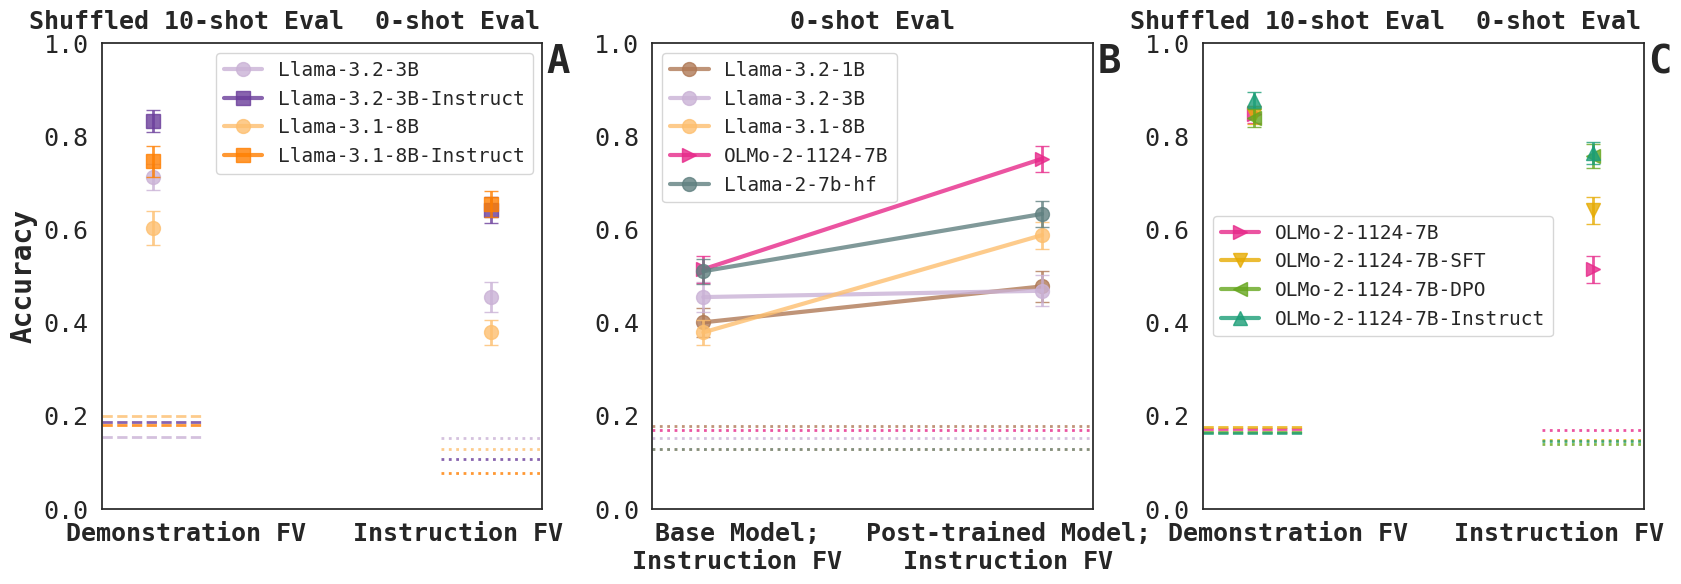

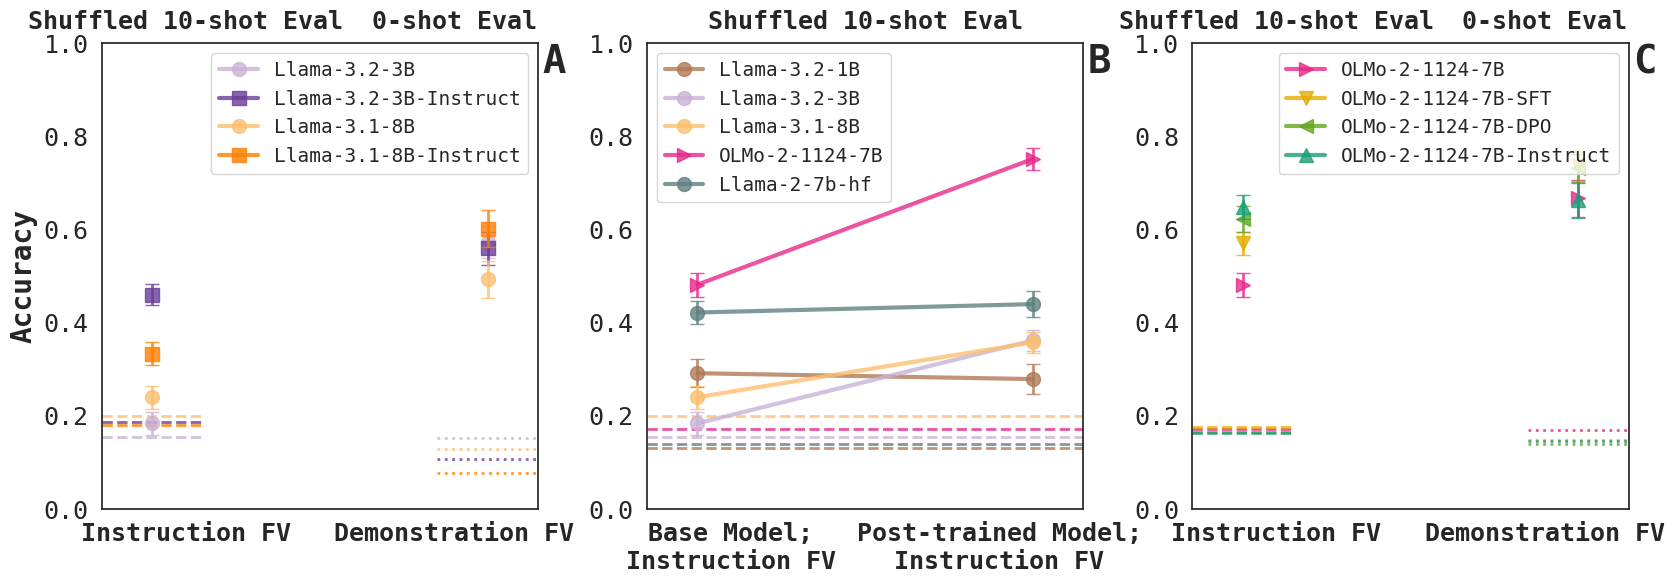

In [12]:
from shared_visualization_utils import BASE_MODELS, MAIN_PLOT_MODELS, OLMO_MODELS, plot_connected_scatter

matched_eval_cols_and_baselines = [
    (
        "ICL FV shuffled 10-shot (20 heads)",
        FEW_SHOT_SHUFFLED_BASELINE_METRICS,
    ),
    ("Prompt FV 0-shot (20 heads)", ZERO_SHOT_BASELINE_METRICS),
]

unmatched_eval_cols_and_baselines = [
    (
        "Prompt FV shuffled 10-shot (20 heads)",
        FEW_SHOT_SHUFFLED_BASELINE_METRICS,
    ),
    ("ICL FV 0-shot (20 heads)", ZERO_SHOT_BASELINE_METRICS),
]

base_model_instruct_fv_matched_eval_cols_and_baselines = [
    (["Prompt FV 0-shot (20 heads)", "Instruct model FV 0-shot (20 heads)"], ZERO_SHOT_BASELINE_METRICS),
]

base_model_instruct_fv_unmatched_eval_cols_and_baselines = [
    (
        ["Prompt FV shuffled 10-shot (20 heads)", "Instruct model FV shuffled 10-shot (20 heads)"],
        FEW_SHOT_SHUFFLED_BASELINE_METRICS,
    ),
]


N_YTICKS = 6


suffix_to_models_and_metrics = {
    "matched_evals": [
        (MAIN_PLOT_MODELS, matched_eval_cols_and_baselines, "upper right"),
        (BASE_MODELS, base_model_instruct_fv_matched_eval_cols_and_baselines, "upper left"),
        (OLMO_MODELS, matched_eval_cols_and_baselines, "center left"),
    ],
    "unmatched_evals": [
        (MAIN_PLOT_MODELS, unmatched_eval_cols_and_baselines, "upper right"),
        (BASE_MODELS, base_model_instruct_fv_unmatched_eval_cols_and_baselines, "upper left"),
        (OLMO_MODELS, unmatched_eval_cols_and_baselines, "upper right"),
    ],
}


N_YTICKS = 6


for figure_suffix, models_and_metrics in suffix_to_models_and_metrics.items():
    n = len(models_and_metrics)
    fig, axes = plt.subplots(1, n, figsize=(PANEL_WIDTH * n + (n - 1), PANEL_HEIGHT))

    for i, (models, metrics, legend_loc) in enumerate(models_and_metrics):
        plot_connected_scatter(
            combined_model_dicts,
            models,
            metric_and_baseline_names=metrics,
            metric_labels=None
            if i != 1
            else {
                "Prompt FV 0-shot (20 heads)": "Base Model;\nInstruction FV",
                "Instruct model FV 0-shot (20 heads)": "Post-trained Model;\nInstruction FV",
                "Prompt FV shuffled 10-shot (20 heads)": "Base Model;\nInstruction FV",
                "Instruct model FV shuffled 10-shot (20 heads)": "Post-trained Model;\nInstruction FV",
            },
            ax=axes[i],
            fontsize=20,
            fontfamily="monospace",
            font_inc=0,
            width=PANEL_WIDTH,
            height=PANEL_HEIGHT,
            legend_outside=False,
            # legend_loc=(0.2, 0.25),
            legend_loc=legend_loc,
            legend_fontsize=14,
            yticks=np.linspace(0, 1, N_YTICKS),
            xtick_nudges=[0.1, -0.1],
            # baseline_annotation_nudges={
            #     "10-shot": -0.05,
            #     "Shuffled 10-shot": -0.05,
            # },
            should_show=False,
            # show_legend=i == 0,
            ylabel="Accuracy" if i == 0 else "",
            annotate_panel=chr(ord("A") + i),
        )

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.25)
    # save_plot(f"rq1_combined_{figure_suffix}_{LAYER_PLOT_SUFFIX}.pdf")
    plt.show()


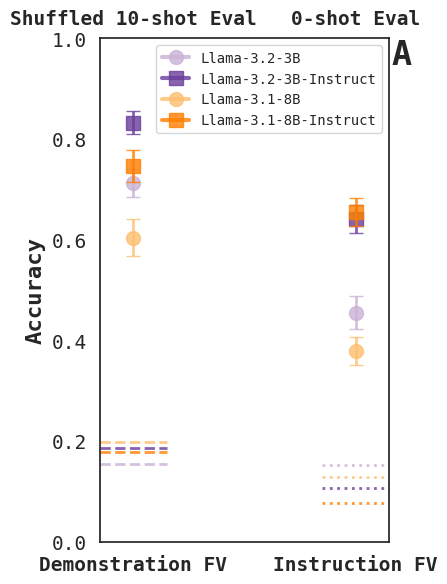

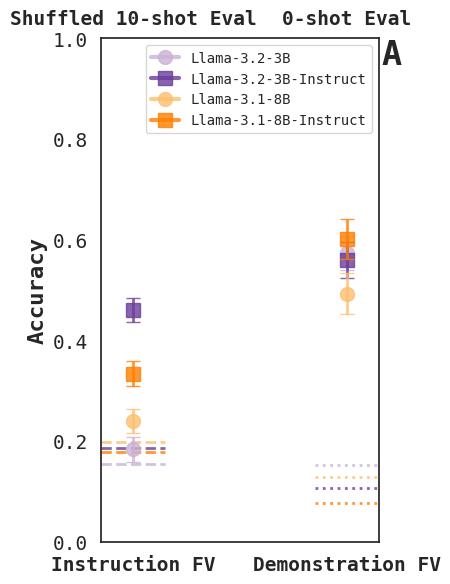

In [13]:
from shared_visualization_utils import MAIN_PLOT_MODELS, plot_connected_scatter

matched_eval_cols_and_baselines = [
    (
        "ICL FV shuffled 10-shot (20 heads)",
        FEW_SHOT_SHUFFLED_BASELINE_METRICS,
    ),
    ("Prompt FV 0-shot (20 heads)", ZERO_SHOT_BASELINE_METRICS),
]

unmatched_eval_cols_and_baselines = [
    (
        "Prompt FV shuffled 10-shot (20 heads)",
        FEW_SHOT_SHUFFLED_BASELINE_METRICS,
    ),
    ("ICL FV 0-shot (20 heads)", ZERO_SHOT_BASELINE_METRICS),
]


for figure_suffix, metric_and_baseline_names in (
    ("matched_evals", matched_eval_cols_and_baselines),
    ("unmatched_evals", unmatched_eval_cols_and_baselines),
):
    plot_connected_scatter(
        combined_model_dicts,
        MAIN_PLOT_MODELS,
        metric_and_baseline_names=metric_and_baseline_names,
        fontsize=16,
        fontfamily="monospace",
        font_inc=0,
        width=PANEL_WIDTH - 0.5,
        height=PANEL_HEIGHT,
        legend_outside=False,
        # legend_loc=(0.2, 0.25),
        legend_loc="upper right",
        legend_fontsize=10,
        yticks=np.linspace(0, 1, 6),
        # baseline_annotation_nudges={
        #     "10-shot": -0.05,
        #     "Shuffled 10-shot": -0.05,
        # },
        should_show=False,
        # show_legend=i == 0,
        # ylabel="Accuracy" if i == 0 else "",
        annotate_panel="A",
    )

    plt.tight_layout()
    save_plot(f"rq1_main_results_{figure_suffix}_{LAYER_PLOT_SUFFIX}.pdf")
    plt.show()


# RQ 1.2-3 -- base model, instruct FV & OLMo models


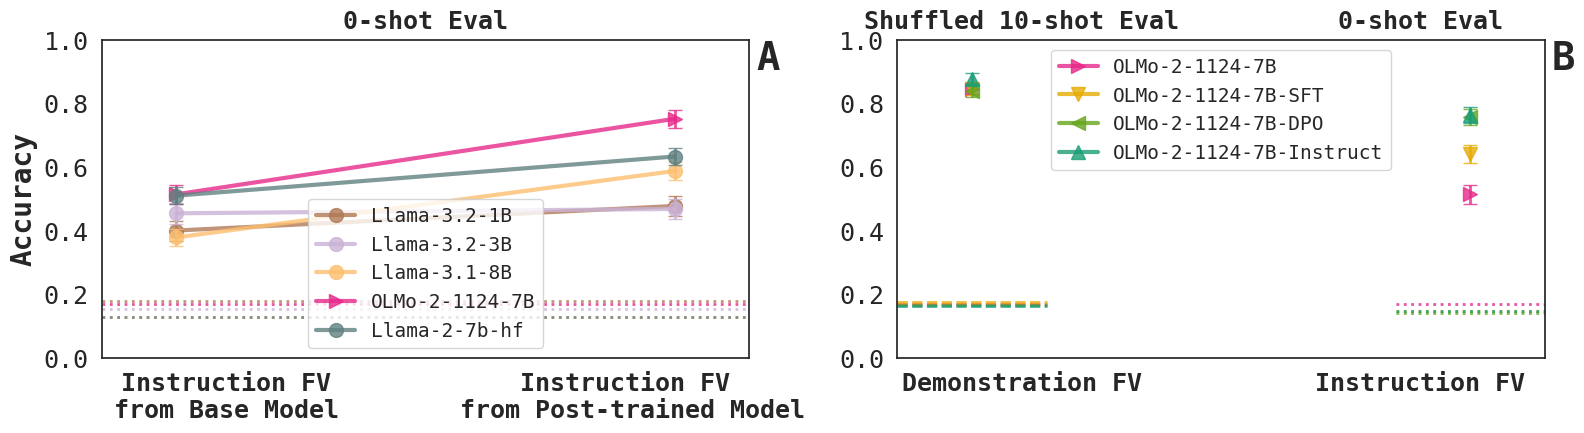

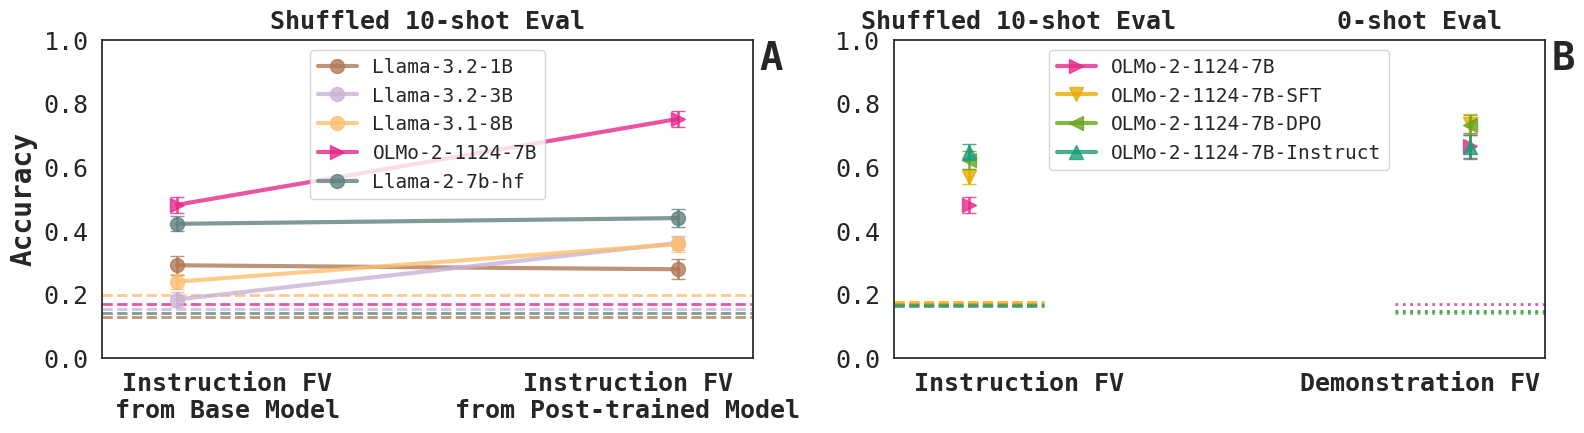

In [14]:
from shared_visualization_utils import BASE_MODELS, MAIN_PLOT_MODELS, OLMO_MODELS, plot_connected_scatter

matched_eval_cols_and_baselines = [
    (
        "ICL FV shuffled 10-shot (20 heads)",
        FEW_SHOT_SHUFFLED_BASELINE_METRICS,
    ),
    ("Prompt FV 0-shot (20 heads)", ZERO_SHOT_BASELINE_METRICS),
]

unmatched_eval_cols_and_baselines = [
    (
        "Prompt FV shuffled 10-shot (20 heads)",
        FEW_SHOT_SHUFFLED_BASELINE_METRICS,
    ),
    ("ICL FV 0-shot (20 heads)", ZERO_SHOT_BASELINE_METRICS),
]

base_model_instruct_fv_matched_eval_cols_and_baselines = [
    (["Prompt FV 0-shot (20 heads)", "Instruct model FV 0-shot (20 heads)"], ZERO_SHOT_BASELINE_METRICS),
]

base_model_instruct_fv_unmatched_eval_cols_and_baselines = [
    (
        ["Prompt FV shuffled 10-shot (20 heads)", "Instruct model FV shuffled 10-shot (20 heads)"],
        FEW_SHOT_SHUFFLED_BASELINE_METRICS,
    ),
]


N_YTICKS = 6


suffix_to_models_and_metrics = {
    "matched_evals": [
        # (MAIN_PLOT_MODELS, matched_eval_cols_and_baselines, "upper right"),
        (BASE_MODELS, base_model_instruct_fv_matched_eval_cols_and_baselines, "lower center"),
        (OLMO_MODELS, matched_eval_cols_and_baselines, "upper center"),
    ],
    "unmatched_evals": [
        # (MAIN_PLOT_MODELS, unmatched_eval_cols_and_baselines, "upper right"),
        (
            BASE_MODELS,
            base_model_instruct_fv_unmatched_eval_cols_and_baselines,
            ("upper left" if USE_ONE_THIRD_LAYER else "upper center"),
        ),
        (OLMO_MODELS, unmatched_eval_cols_and_baselines, "upper center"),
    ],
}


N_YTICKS = 6

panel_width = PANEL_WIDTH
panel_height = PANEL_HEIGHT - 1

for figure_suffix, models_and_metrics in suffix_to_models_and_metrics.items():
    n = len(models_and_metrics)
    fig, axes = plt.subplots(1, 2, figsize=(16, 4.5))

    for i, (models, metrics, legend_loc) in enumerate(models_and_metrics):
        plot_connected_scatter(
            combined_model_dicts,
            models,
            metric_and_baseline_names=metrics,
            metric_labels=None
            if i != 0
            else {
                # "Prompt FV 0-shot (20 heads)": "Base Model;\nInstruction FV",
                # "Instruct model FV 0-shot (20 heads)": "Post-trained Model;\nInstruction FV",
                # "Prompt FV shuffled 10-shot (20 heads)": "Base Model;\nInstruction FV",
                # "Instruct model FV shuffled 10-shot (20 heads)": "Post-trained Model;\nInstruction FV",
                "Prompt FV 0-shot (20 heads)": "Instruction FV\nfrom Base Model",
                "Instruct model FV 0-shot (20 heads)": "Instruction FV\n from Post-trained Model",
                "Prompt FV shuffled 10-shot (20 heads)": "Instruction FV\nfrom Base Model",
                "Instruct model FV shuffled 10-shot (20 heads)": "Instruction FV\nfrom Post-trained Model",
            },
            ax=axes[i],
            fontsize=20,
            fontfamily="monospace",
            font_inc=0,
            # width=PANEL_WIDTH,
            # height=PANEL_HEIGHT,
            legend_outside=False,
            # legend_loc=(0.2, 0.25),
            legend_loc=legend_loc,
            legend_fontsize=14,
            yticks=np.linspace(0, 1, N_YTICKS),
            xtick_nudges=[0.1, -0.1],
            # baseline_annotation_nudges={
            #     "10-shot": -0.05,
            #     "Shuffled 10-shot": -0.05,
            # },
            should_show=False,
            # show_legend=i == 0,
            ylabel="Accuracy" if i == 0 else "",
            annotate_panel=chr(ord("A") + i),
        )

    plt.tight_layout()
    # plt.subplots_adjust(wspace=0.3)
    save_plot(f"finding_5_base_inst_olmo_{figure_suffix}_{LAYER_PLOT_SUFFIX}.pdf")
    plt.show()


### Using the above form to make an appendix plot with other models

In [ ]:
from shared_visualization_utils import BASE_MODELS, MAIN_PLOT_MODELS, OLMO_MODELS, plot_connected_scatter

matched_eval_cols_and_baselines = [
    (
        "ICL FV shuffled 10-shot (20 heads)",
        FEW_SHOT_SHUFFLED_BASELINE_METRICS,
    ),
    ("Prompt FV 0-shot (20 heads)", ZERO_SHOT_BASELINE_METRICS),
]

unmatched_eval_cols_and_baselines = [
    (
        "Prompt FV shuffled 10-shot (20 heads)",
        FEW_SHOT_SHUFFLED_BASELINE_METRICS,
    ),
    ("ICL FV 0-shot (20 heads)", ZERO_SHOT_BASELINE_METRICS),
]


N_YTICKS = 6
NON_OLMO_APPENDIX_MODELS = [model for model in APPENDIX_MODELS if model not in OLMO_MODELS]

suffix_to_models_and_metrics = {
    "matched_evals": [
        # (MAIN_PLOT_MODELS, matched_eval_cols_and_baselines, "upper right"),
        (NON_OLMO_APPENDIX_MODELS, matched_eval_cols_and_baselines, "lower center"),
        (OLMO_MODELS, matched_eval_cols_and_baselines, "upper center"),
    ],
    "unmatched_evals": [
        # (MAIN_PLOT_MODELS, unmatched_eval_cols_and_baselines, "upper right"),
        (
            NON_OLMO_APPENDIX_MODELS,
            unmatched_eval_cols_and_baselines,
            ("upper left" if USE_ONE_THIRD_LAYER else "upper center"),
        ),
        (OLMO_MODELS, unmatched_eval_cols_and_baselines, "upper center"),
    ],
}


N_YTICKS = 6

panel_width = PANEL_WIDTH
panel_height = PANEL_HEIGHT - 1

for figure_suffix, models_and_metrics in suffix_to_models_and_metrics.items():
    n = len(models_and_metrics)
    fig, axes = plt.subplots(1, 2, figsize=(16, 4.5))

    for i, (models, metrics, legend_loc) in enumerate(models_and_metrics):
        plot_connected_scatter(
            combined_model_dicts,
            models,
            metric_and_baseline_names=metrics,
            metric_labels=None
            if i != 0
            else {
                "Prompt FV 0-shot (20 heads)": "Base Model\nInstruction FV",
                "Instruct model FV 0-shot (20 heads)": "Post-trained Model\nInstruction FV",
                "Prompt FV shuffled 10-shot (20 heads)": "Base Model\nInstruction FV",
                "Instruct model FV shuffled 10-shot (20 heads)": "Post-trained Model\nInstruction FV",
            },
            ax=axes[i],
            fontsize=20,
            fontfamily="monospace",
            font_inc=0,
            # width=PANEL_WIDTH,
            # height=PANEL_HEIGHT,
            legend_outside=False,
            # legend_loc=(0.2, 0.25),
            legend_loc=legend_loc,
            legend_fontsize=14,
            yticks=np.linspace(0, 1, N_YTICKS),
            xtick_nudges=[0.1, -0.1],
            # baseline_annotation_nudges={
            #     "10-shot": -0.05,
            #     "Shuffled 10-shot": -0.05,
            # },
            should_show=False,
            # show_legend=i == 0,
            ylabel="Accuracy" if i == 0 else "",
            annotate_panel=chr(ord("A") + i),
        )

    plt.tight_layout()
    # plt.subplots_adjust(wspace=0.3)
    save_plot(f"appendix_finding_1_more_models_{figure_suffix}_{LAYER_PLOT_SUFFIX}.pdf")
    plt.show()


# Same as above, but with 10 heads, to make a point about the smaller models

In [ ]:
from shared_visualization_utils import BASE_MODELS, MAIN_PLOT_MODELS, OLMO_MODELS, plot_connected_scatter

matched_eval_cols_and_baselines = [
    (
        "ICL FV shuffled 10-shot (10 heads)",
        FEW_SHOT_SHUFFLED_BASELINE_METRICS,
    ),
    ("Prompt FV 0-shot (10 heads)", ZERO_SHOT_BASELINE_METRICS),
]

unmatched_eval_cols_and_baselines = [
    (
        "Prompt FV shuffled 10-shot (10 heads)",
        FEW_SHOT_SHUFFLED_BASELINE_METRICS,
    ),
    ("ICL FV 0-shot (10 heads)", ZERO_SHOT_BASELINE_METRICS),
]

base_model_instruct_fv_matched_eval_cols_and_baselines = [
    (["Prompt FV 0-shot (20 heads)", "Instruct model FV 0-shot (10 heads)"], ZERO_SHOT_BASELINE_METRICS),
]

base_model_instruct_fv_unmatched_eval_cols_and_baselines = [
    (
        ["Prompt FV shuffled 10-shot (10 heads)", "Instruct model FV shuffled 10-shot (10 heads)"],
        FEW_SHOT_SHUFFLED_BASELINE_METRICS,
    ),
]


N_YTICKS = 6


suffix_to_models_and_metrics = {
    "matched_evals": [
        # (MAIN_PLOT_MODELS, matched_eval_cols_and_baselines, "upper right"),
        (BASE_MODELS, base_model_instruct_fv_matched_eval_cols_and_baselines, "lower center"),
        (OLMO_MODELS, matched_eval_cols_and_baselines, "upper center"),
    ],
    "unmatched_evals": [
        # (MAIN_PLOT_MODELS, unmatched_eval_cols_and_baselines, "upper right"),
        (
            BASE_MODELS,
            base_model_instruct_fv_unmatched_eval_cols_and_baselines,
            ("upper left" if USE_ONE_THIRD_LAYER else "upper center"),
        ),
        (OLMO_MODELS, unmatched_eval_cols_and_baselines, "upper center"),
    ],
}


N_YTICKS = 6

panel_width = PANEL_WIDTH
panel_height = PANEL_HEIGHT - 1

for figure_suffix, models_and_metrics in suffix_to_models_and_metrics.items():
    n = len(models_and_metrics)
    fig, axes = plt.subplots(1, 2, figsize=(16, 4.5))

    for i, (models, metrics, legend_loc) in enumerate(models_and_metrics):
        plot_connected_scatter(
            combined_model_dicts,
            models,
            metric_and_baseline_names=metrics,
            metric_labels=None
            if i != 0
            else {
                "Prompt FV 0-shot (20 heads)": "Base Model\nInstruction FV",
                "Instruct model FV 0-shot (20 heads)": "Post-trained Model\nInstruction FV",
                "Prompt FV shuffled 10-shot (20 heads)": "Base Model\nInstruction FV",
                "Instruct model FV shuffled 10-shot (20 heads)": "Post-trained Model\nInstruction FV",
            },
            ax=axes[i],
            fontsize=20,
            fontfamily="monospace",
            font_inc=0,
            # width=PANEL_WIDTH,
            # height=PANEL_HEIGHT,
            legend_outside=False,
            # legend_loc=(0.2, 0.25),
            legend_loc=legend_loc,
            legend_fontsize=14,
            yticks=np.linspace(0, 1, N_YTICKS),
            xtick_nudges=[0.1, -0.1],
            # baseline_annotation_nudges={
            #     "10-shot": -0.05,
            #     "Shuffled 10-shot": -0.05,
            # },
            should_show=False,
            # show_legend=i == 0,
            ylabel="Accuracy" if i == 0 else "",
            annotate_panel=chr(ord("A") + i),
        )

    plt.tight_layout()
    # plt.subplots_adjust(wspace=0.3)
    # save_plot(f"finding_5_base_inst_olmo_10_heads_{figure_suffix}_{LAYER_PLOT_SUFFIX}.pdf")
    plt.show()


# RQ1.1 -- base model, instruct FV


In [ ]:
from palettable.colorbrewer.qualitative import Paired_12 as cmap
from shared_visualization_utils import plot_connected_scatter

matched_eval_cols_and_baselines = [
    (["Prompt FV 0-shot (20 heads)", "Instruct model FV 0-shot (20 heads)"], ZERO_SHOT_BASELINE_METRICS),
]

unmatched_eval_cols_and_baselines = [
    (
        ["Prompt FV shuffled 10-shot (20 heads)", "Instruct model FV shuffled 10-shot (20 heads)"],
        FEW_SHOT_SHUFFLED_BASELINE_METRICS,
    ),
]


N_YTICKS = 6


BASE_MODELS = ["Llama-3.2-1B", "Llama-3.2-3B", "Llama-3.1-8B", "OLMo-2-1124-7B", "Llama-2-7b-hf"]


for figure_suffix, metric_and_baseline_names in (
    ("matched_evals", matched_eval_cols_and_baselines),
    ("unmatched_evals", unmatched_eval_cols_and_baselines),
):
    metric_group_names = METRIC_GROUP_NAMES[0 if "unmatched" in figure_suffix else 1]

    plot_connected_scatter(
        combined_model_dicts,
        BASE_MODELS,
        metric_and_baseline_names=metric_and_baseline_names,
        metric_group_names=metric_group_names,
        fontsize=14,
        fontfamily="monospace",
        font_inc=0,
        width=PANEL_WIDTH,
        height=PANEL_HEIGHT,
        legend_outside=False,
        # legend_loc=(0.2, 0.25),
        legend_loc="upper left",
        legend_fontsize=12,
        yticks=np.linspace(0, 1, 6),
        # baseline_annotation_nudges={
        #     "10-shot": -0.05,
        #     "Shuffled 10-shot": -0.05,
        # },
        should_show=False,
        # show_legend=i == 0,
        # ylabel="Accuracy" if i == 0 else "",
        # annotate_panel=chr(ord("A") + i),
    )

    plt.tight_layout()
    save_plot(f"rq1_1_instruct_fv_{figure_suffix}_{LAYER_PLOT_SUFFIX}.pdf")
    plt.show()


# RQ1.2: OLMo models


In [ ]:
matched_eval_cols_and_baselines = [
    (
        "ICL FV shuffled 10-shot (20 heads)",
        FEW_SHOT_SHUFFLED_BASELINE_METRICS,
    ),
    ("Prompt FV 0-shot (20 heads)", ZERO_SHOT_BASELINE_METRICS),
]

unmatched_eval_cols_and_baselines = [
    (
        "Prompt FV shuffled 10-shot (20 heads)",
        FEW_SHOT_SHUFFLED_BASELINE_METRICS,
    ),
    ("ICL FV 0-shot (20 heads)", ZERO_SHOT_BASELINE_METRICS),
]


for figure_suffix, metric_and_baseline_names in (
    ("matched_evals", matched_eval_cols_and_baselines),
    ("unmatched_evals", unmatched_eval_cols_and_baselines),
):
    plot_connected_scatter(
        combined_model_dicts,
        ["OLMo-2-1124-7B", "OLMo-2-1124-7B-SFT", "OLMo-2-1124-7B-DPO", "OLMo-2-1124-7B-Instruct"],
        metric_and_baseline_names=metric_and_baseline_names,
        fontsize=14,
        fontfamily="monospace",
        font_inc=0,
        width=PANEL_WIDTH,
        height=PANEL_HEIGHT,
        legend_outside=False,
        # legend_loc=(0.125, 0.25),
        legend_loc=(0.02, 0.3) if figure_suffix == "matched_evals" else "upper right",
        legend_fontsize=12,
        yticks=np.linspace(0, 1, 6),
        baseline_annotation_nudges={
            "10-shot": -0.01,
            "Shuffled 10-shot": -0.03,
        },
        should_show=False,
        # show_legend=i == 0,
        # ylabel="Accuracy" if i == 0 else "",
        # annotate_panel=chr(ord("A") + i),
    )

    plt.tight_layout()
    save_plot(f"rq3_olmo_results_{figure_suffix}_{LAYER_PLOT_SUFFIX}.pdf")
    plt.show()


# Digging into an oddity


In [ ]:
model = "Llama-3.1-8B-Instruct"

mdf = result_with_same_layer_acc_df[result_df.model == model]

parts = ["zs", "by_layer", "40"]
[c for c in mdf.columns if all(p in c for p in parts)]

comparison_cols = [
    "prompt_type",
    "dataset",
    "zs_universal_both_all_20_heads_by_layer_acc",
    "zs_universal_both_all_40_heads_by_layer_acc",
]
min_df = mdf[comparison_cols]
min_df = min_df[~min_df.isna().any(axis=1)]
min_df = min_df.assign(
    max_diff=min_df.apply(
        lambda row: row.zs_universal_both_all_20_heads_by_layer_acc[14][1]
        - row.zs_universal_both_all_40_heads_by_layer_acc[15][1],
        axis=1,
    ),
)
min_df[min_df.dataset == "park-country"]

In [ ]:
parts = ["zs", "max_acc_layer", "40"]
mdf[["zs_both_20_max_acc_layer", "zs_both_40_max_acc_layer"]]

In [ ]:
prev_res_by_n_top_heads = defaultdict(list)

for n_top_heads in N_TOP_HEADS_VALUES:
    res_path = f"/checkpoint/guyd/function_vectors/full_results_prompt_based_short/Llama-3.1-8B-Instruct/park-country/zs_results_universal_both_all_{n_top_heads}_heads_layer_sweep.json"
    print(res_path)
    with open(res_path, "r") as f:
        prev_res_by_n_top_heads[n_top_heads] = json.load(f)

prev_res_by_n_top_heads.keys(), prev_res_by_n_top_heads[10].keys()

In [ ]:
rerun_res_by_n_top_heads = defaultdict(list)

for n_top_heads in N_TOP_HEADS_VALUES:
    res_path = f"/checkpoint/guyd/function_vectors/full_results_prompt_based_short/Test-3.1-8B-Instruct/park-country/zs_results_universal_both_all_{n_top_heads}_heads_layer_sweep.json"
    print(res_path)
    with open(res_path, "r") as f:
        rerun_res_by_n_top_heads[n_top_heads] = json.load(f)

rerun_res_by_n_top_heads.keys(), rerun_res_by_n_top_heads[10].keys()

In [ ]:
for layer in range(32):
    print(
        [
            (
                prev_res_by_n_top_heads[n][str(layer)]["intervention_topk"][""][0][1]
                - rerun_res_by_n_top_heads[n][str(layer)]["intervention_topk"][""][0][1]
            )
            for n in N_TOP_HEADS_VALUES
        ]
    )


# Older Plots


In [ ]:
def plot_metric_grouped_bar_chart(
    model_dicts: typing.Dict[str, typing.Dict[str, float]],
    models: typing.Sequence[str],
    metric_names: typing.Sequence[str],
    colors: typing.Sequence[str] = None,
    title: str | None = None,
    metric_labels: typing.Sequence[str] | None = None,
    ylabel: str = "Accuracy",
    fontsize: int = 20,
    font_inc: int = 4,
    legend_outside: bool = True,
    width: float = 12.0,
    legend_width: float = 2.0,
    height: float = 8.0,
):
    n_metrics = len(metric_names)
    n_models = len(models)

    if metric_labels is not None and len(metric_labels) != n_metrics:
        raise ValueError(
            f"Length of metric_labels ({len(metric_labels)}) does not match number of metrics ({n_metrics})."
        )

    if colors is not None and len(colors) != n_metrics:
        raise ValueError(f"Length of colors ({len(colors)}) does not match number of metrics ({n_metrics}).")

    bar_width = 0.8 / n_metrics
    bar_positions = np.arange(n_models)

    fig, ax = plt.subplots(figsize=(width + (legend_width * int(legend_outside)), height))

    for i, metric_name in enumerate(metric_names):
        metric_values = [model_dicts[model].get(metric_name, np.nan) for model in models]
        if np.any(np.isnan(metric_values)):
            logger.warning(f"Missing data for metric {metric_name} in models {models}.")
            continue
        bar_kwargs = dict(width=bar_width, label=metric_name)
        if colors is not None:
            bar_kwargs["color"] = colors[i]
        ax.bar(bar_positions + i * bar_width, metric_values, **bar_kwargs)
        if metric_labels is not None:
            for j, bp in enumerate(bar_positions):
                ax.text(
                    bp + (i * bar_width),
                    0.02,
                    metric_labels[i],
                    ha="center",
                    fontsize=fontsize - font_inc,
                    fontweight="semibold",
                    rotation="vertical",
                )

    ax.set_xticks(bar_positions + bar_width * (n_metrics - 1) / 2)
    ax.set_xticklabels(models, fontsize=fontsize + font_inc)
    ax.set_ylabel(ylabel, fontsize=fontsize + font_inc)
    if title is not None:
        ax.set_title(title, fontsize=fontsize + (2 * font_inc))
    legend_kwargs = dict(fontsize=fontsize - (font_inc * 2))
    if legend_outside:
        legend_kwargs["bbox_to_anchor"] = (1.05, 1)
        legend_kwargs["loc"] = "upper left"
    ax.legend(**legend_kwargs)
    ax.tick_params(axis="y", labelsize=fontsize)
    # plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


summary_cols_nice_names = [
    "10-shot",
    # 'Top-1 prompt',
    "Top-5 prompts (mean)",
    "0-shot",
    "ICL FV 0-shot (10 heads)",
    "Prompt FV 0-shot (10 heads)",
    "ICL FV 0-shot (20 heads)",
    "Prompt FV 0-shot (20 heads)",
]

metric_labels = [
    "ICL baseline (10-shot)",
    "Prompt baseline (Top-5)",
    "0-shot",
    "0-shot + ICL FV (10 heads)",
    "0-shot + Prompt FV (10)",
    "0-shot + ICL FV (20)",
    "0-shot + Prompt FV (20)",
]


ordered_color_indices = [
    10,
    11,
    6,
    2,
    7,
    3,
]

colors = [cmap.mpl_colors[i] for i in ordered_color_indices]
colors.insert(0, (0.8, 0.8, 0.8))

# plot_metric_grouped_bar_chart(
#     zero_shot_model_dicts,
#     ["Llama-3.2-3B", "Llama-3.2-3B-Instruct"],
#     summary_cols_nice_names,
#     colors=colors,
#     metric_labels=metric_labels,
# )


for i in range(0, len(RELEVANT_MODELS), 2):
    if "OLMo" in RELEVANT_MODELS[i]:
        continue

    plot_metric_grouped_bar_chart(
        zero_shot_model_dicts,
        RELEVANT_MODELS[i : i + 2],
        summary_cols_nice_names,
        colors=colors,
        metric_labels=metric_labels,
        title=RELEVANT_MODELS[i] + " family | 0-shot",
    )

OLMO_MODELS = [model for model in RELEVANT_MODELS if "OLMo" in model]
plot_metric_grouped_bar_chart(
    zero_shot_model_dicts,
    OLMO_MODELS,
    summary_cols_nice_names,
    colors=colors,
    metric_labels=metric_labels,
    title=OLMO_MODELS[0] + " family | 0-shot",
    fontsize=16,
    width=16,
)

In [ ]:
shuffled_10_shot_cols_nice_names = [
    "10-shot",
    # 'Top-1 prompt',
    "Top-5 prompts (mean)",
    "Shuffled 10-shot",
    "ICL FV shuffled 10-shot (10 heads)",
    "Prompt FV shuffled 10-shot (10 heads)",
    "ICL FV shuffled 10-shot (20 heads)",
    "Prompt FV shuffled 10-shot (20 heads)",
]


shuffled_10_shot_metric_labels = [
    "ICL baseline (10-shot)",
    "Prompt baseline (Top-5)",
    "Shuffled 10-shot",
    "S 10-shot + ICL FV (10 heads)",
    "S 10-shot + Prompt FV (10)",
    "S 10-shot + ICL FV (20)",
    "S 10-shot + Prompt FV (20)",
]


for i in range(0, len(RELEVANT_MODELS), 2):
    if "OLMo" in RELEVANT_MODELS[i]:
        continue

    plot_metric_grouped_bar_chart(
        shuffled_ten_shot_model_dicts,
        RELEVANT_MODELS[i : i + 2],
        shuffled_10_shot_cols_nice_names,
        colors=colors,
        metric_labels=shuffled_10_shot_metric_labels,
        title=RELEVANT_MODELS[i] + " family | shuffled 10-shot",
    )


OLMO_MODELS = [model for model in RELEVANT_MODELS if "OLMo" in model]
plot_metric_grouped_bar_chart(
    shuffled_ten_shot_model_dicts,
    OLMO_MODELS,
    shuffled_10_shot_cols_nice_names,
    colors=colors,
    metric_labels=shuffled_10_shot_metric_labels,
    title=OLMO_MODELS[0] + " family | shuffled 10-shot",
    fontsize=16,
    width=16,
)

In [ ]:
from scipy.stats import mannwhitneyu


def _key_to_table(key):
    return ", ".join(key)


def print_statistical_significance_table(
    df: pd.DataFrame,
    models: typing.Sequence[str],
    columns: typing.Sequence[str],
    matched: bool = True,
):
    sub_df = df[df.model.isin(models)].copy()
    sub_df = sub_df[sub_df[columns].notna().any(axis=1)]

    if matched:
        datasets_by_model_and_col = dict()
        for model, col in itertools.product(models, columns):
            datasets_by_model_and_col[(model, col)] = set(
                sub_df[(sub_df["model"] == model) & (sub_df[col].notna())]["dataset"].unique().tolist()
            )

        shared_datasets = set.intersection(*datasets_by_model_and_col.values())
        sub_df = sub_df[sub_df["dataset"].isin(shared_datasets)]

        data_by_model_and_col = dict()
        for model, col in itertools.product(models, columns):
            data_by_model_and_col[(model, METRIC_RENAMES[col])] = (
                sub_df[(sub_df["model"] == model) & (sub_df[col].notna())]
                .sort_values("dataset")
                .groupby("dataset")[col]
                .mean()
            )  # .values

        result_rows = []
        for first_key, first_scores in data_by_model_and_col.items():
            key_row = dict(key=_key_to_table(first_key))
            for second_key, second_scores in data_by_model_and_col.items():
                sk = _key_to_table(second_key)
                if (first_scores.index != second_scores.index).any():
                    raise ValueError(f"Datasets do not match for {first_key} and {second_key}")

                if first_key == second_key:
                    key_row[sk] = ""

                else:
                    # print(first_key, first_scores.shape, second_key, second_scores.shape)
                    stat, p_value = mannwhitneyu(first_scores, second_scores)
                    key_row[sk] = f"{(first_scores - second_scores).mean():.3f}, {stat:.3f} ({p_value:.3f})"

            result_rows.append(key_row)

        return result_rows

    return sub_df


mods = ["Llama-3.2-3B", "Llama-3.2-3B-Instruct"]
cols = [
    "top_n_prompt_acc",
    # "0_shot_acc",
    "zs_universal_both_all_20_heads_same_layer_acc",
    "zs_universal_icl_all_20_heads_same_layer_acc",
]
d = print_statistical_significance_table(
    matched_datasets_result_with_same_layer_acc_df,
    mods,
    cols,
    matched=True,
)

display(Markdown(tabulate.tabulate(d, headers="keys", tablefmt="github")))


In [ ]:
mods = [m for m in RELEVANT_MODELS if "OLMo" in m]
cols = [
    # "top_n_prompt_acc",
    # "0_shot_acc",
    "zs_universal_both_all_20_heads_same_layer_acc",
    # "zs_universal_icl_all_10_heads_same_layer_acc",
]
d = print_statistical_significance_table(
    matched_datasets_result_with_same_layer_acc_df,
    mods,
    cols,
    matched=True,
)

display(Markdown(tabulate.tabulate(d, headers="keys", tablefmt="github")))
